In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [46]:
import pandas as pd
import os
import random

image_base_dir = "/kaggle/input/multimodal-dataset/img final/img final/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset" 
processed_file = '/kaggle/input/multimodal-dataset/preprocessed_data.csv'

clinical_df = pd.read_csv(processed_file)

print("Collecting image paths...")
image_data = []


classes = {
    'Malignant cases': 1,      # Cancer
    'Normal cases': 0,         # Healthy        
}

print("Exploring dataset structure...")
if os.path.exists(image_base_dir):
    folders = os.listdir(image_base_dir)
    print(f"Found folders: {folders}")
    
else:
    print(f" Warning: Base directory not found: {image_base_dir}")

for folder_name, label in classes.items():
    folder_path = os.path.join(image_base_dir, folder_name)
    if os.path.exists(folder_path):
        files = os.listdir(folder_path)
        print(f"  Found {len(files)} images in '{folder_name}'")
        for f in files:
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                image_data.append({
                    'image_path': os.path.join(folder_path, f),
                    'label': label
                })
    else:
        print(f" Warning: Folder not found: {folder_path}")

if len(image_data) == 0:
    print("Trying alternative approach - searching for images in all subdirectories...")
    for root, dirs, files in os.walk(image_base_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                # Try to infer label from folder name
                folder_name = os.path.basename(root)
                label = 0  # default to normal
                if 'malignant' in folder_name.lower():
                    label = 1
                elif 'normal' in folder_name.lower():
                    label = 0
                
                image_data.append({
                    'image_path': os.path.join(root, file),
                    'label': label
                })

image_df = pd.DataFrame(image_data)

if len(image_df) == 0:
    print("ERROR: No images found! Please check the dataset structure.")
else:
    print(f"Successfully collected {len(image_df)} images")

print(f"\nMerging {len(clinical_df)} Clinical records with {len(image_df)} Images...")

cancer_column = 'has_cancer' 

if cancer_column not in clinical_df.columns:
    print(f"Available columns in clinical data: {clinical_df.columns.tolist()}")
    # Try to find a similar column
    possible_columns = [col for col in clinical_df.columns if 'cancer' in col.lower() or 'diagnosis' in col.lower()]
    if possible_columns:
        cancer_column = possible_columns[0]
        print(f"Using column '{cancer_column}' for cancer status")
    else:
        print(" ERROR: No cancer status column found in clinical data")

# Split by Class
clin_cancer = clinical_df[clinical_df[cancer_column] == 1]
clin_healthy = clinical_df[clinical_df[cancer_column] == 0]

img_cancer = image_df[image_df['label'] == 1]
img_healthy = image_df[image_df['label'] == 0]

print(f"Clinical data - Cancer: {len(clin_cancer)}, Healthy: {len(clin_healthy)}")
print(f"Image data - Cancer: {len(img_cancer)}, Healthy: {len(img_healthy)}")

def pair_datasets(clin, img):
    n_samples = min(len(clin), len(img))
    
    if n_samples == 0:
        print("Warning: No samples to pair for one class")
        return pd.DataFrame()
    
    clin = clin.sample(n=n_samples, random_state=42).reset_index(drop=True)
    img = img.sample(n=n_samples, random_state=42).reset_index(drop=True)
    return pd.concat([clin, img[['image_path']]], axis=1)

cancer_pairs = pair_datasets(clin_cancer, img_cancer)
healthy_pairs = pair_datasets(clin_healthy, img_healthy)

final_multimodal = pd.concat([cancer_pairs, healthy_pairs], ignore_index=True)
final_multimodal = final_multimodal.sample(frac=1, random_state=42).reset_index(drop=True)

csv_name = 'lung_cancer_multimodal_pairs.csv'
final_multimodal.to_csv(csv_name, index=False)

print("\n" + "="*50)
print(f" SUCCESS! Created {len(final_multimodal)} matched pairs.")
print(f"   Saved to: {csv_name}")
print("="*50)

if len(final_multimodal) > 0:
    preview_columns = ['PATIENT_ID', 'image_path', cancer_column] if 'PATIENT_ID' in final_multimodal.columns else [final_multimodal.columns[0], 'image_path', cancer_column]
    print(final_multimodal[preview_columns].head())
else:
    print("No pairs were created. Please check the data compatibility.")

Exploring dataset structure...
Found folders: ['IQ-OTH_NCCD lung cancer dataset.txt', 'Normal cases', 'Malignant cases']
  Found 561 images in 'Malignant cases'
  Found 416 images in 'Normal cases'
Successfully collected 977 images

Merging 504 Clinical records with 977 Images...
Clinical data - Cancer: 462, Healthy: 42
Image data - Cancer: 561, Healthy: 416

 SUCCESS! Created 504 matched pairs.
   Saved to: lung_cancer_multimodal_pairs.csv
   demographic.age_at_index  \
0                      72.0   
1                      72.0   
2                      68.0   
3                      76.0   
4                      67.0   

                                          image_path  has_cancer  
0  /kaggle/input/multimodal-dataset/img final/img...           1  
1  /kaggle/input/multimodal-dataset/img final/img...           1  
2  /kaggle/input/multimodal-dataset/img final/img...           0  
3  /kaggle/input/multimodal-dataset/img final/img...           1  
4  /kaggle/input/multimodal-datas

In [48]:
# Install required packages
!pip install transformers timm pytorch-toolbelt albumentations -q
!pip install wandb -q  # for optional logging

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [49]:

df = pd.read_csv('/kaggle/input/multimodal/lung_cancer_multimodal_pairs.csv')

print(f"Dataset shape: {df.shape}")
print(f"Class distribution:\n{df['has_cancer'].value_counts()}")

print("\nFirst 5 rows:")
display(df.head())

print("\nMissing values:")
print(df.isnull().sum())

print("\nClinical features statistics:")
print(df.describe())

Dataset shape: (504, 15)
Class distribution:
has_cancer
1    462
0     42
Name: count, dtype: int64

First 5 rows:


,demographic.age_at_index,demographic.gender,demographic.race,demographic.ethnicity,demographic.vital_status,cases.disease_type,cases.lost_to_followup,diagnoses.age_at_diagnosis,diagnoses.ajcc_pathologic_stage,diagnoses.morphology,diagnoses.residual_disease,treatments.treatment_type,treatments.treatment_intent_type,has_cancer,image_path
0,72.0,1,0,0,0,1,0,26420.0,6,8,0,0,3,1,/kaggle/input/multimodal-dataset/img final/img...
1,72.0,0,3,0,1,1,1,26419.0,6,8,0,2,0,1,/kaggle/input/multimodal-dataset/img final/img...
2,68.0,1,0,0,0,1,0,25065.0,2,7,4,2,3,0,/kaggle/input/multimodal-dataset/img final/img...
3,76.0,1,3,0,1,1,1,28036.0,6,8,4,3,0,1,/kaggle/input/multimodal-dataset/img final/img...
4,67.0,1,3,2,1,1,0,24788.0,8,8,0,2,0,1,/kaggle/input/multimodal-dataset/img final/img...



Missing values:
demographic.age_at_index            0
demographic.gender                  0
demographic.race                    0
demographic.ethnicity               0
demographic.vital_status            0
cases.disease_type                  0
cases.lost_to_followup              0
diagnoses.age_at_diagnosis          0
diagnoses.ajcc_pathologic_stage     0
diagnoses.morphology                0
diagnoses.residual_disease          0
treatments.treatment_type           0
treatments.treatment_intent_type    0
has_cancer                          0
image_path                          0
dtype: int64

Clinical features statistics:
       demographic.age_at_index  demographic.gender  demographic.race  \
count                504.000000          504.000000        504.000000   
mean                  67.283730            0.740079          2.230159   
std                    8.527167            0.439027          1.249494   
min                   39.000000            0.000000          0.000000   
25% 

In [50]:

clinical_features = [
    'demographic.age_at_index', 'demographic.gender', 'demographic.race', 
    'demographic.ethnicity', 'demographic.vital_status', 'cases.disease_type',
    'cases.lost_to_followup', 'diagnoses.age_at_diagnosis', 
    'diagnoses.ajcc_pathologic_stage', 'diagnoses.morphology',
    'diagnoses.residual_disease', 'treatments.treatment_type',
    'treatments.treatment_intent_type'
]


df[clinical_features] = df[clinical_features].fillna(df[clinical_features].median())

scaler = StandardScaler()
df[clinical_features] = scaler.fit_transform(df[clinical_features])

print("Clinical features normalized successfully!")
print(f"Available samples: {len(df)}")

Clinical features normalized successfully!
Available samples: 504


In [51]:
class MultimodalLungCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None, is_train=True):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.is_train = is_train
       
        self.valid_indices = []
        for idx in range(len(self.dataframe)):
            img_path = self.dataframe.iloc[idx]['image_path']
            if os.path.exists(img_path):
                self.valid_indices.append(idx)
            elif is_train:  # Only warn during training
                print(f"Warning: Image not found at index {idx}: {img_path}")
    
    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        row = self.dataframe.iloc[actual_idx]
        
        img_path = row['image_path']
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        clinical_data = torch.FloatTensor(row[clinical_features].values.astype(np.float32))
        
        label = torch.LongTensor([row['has_cancer']]).squeeze()
        
        return {
            'image': image,
            'clinical': clinical_data,
            'label': label,
            'image_path': img_path
        }

In [52]:
# Image transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Data transforms defined successfully!")

Data transforms defined successfully!


In [53]:
import timm

class MultimodalCancerClassifier(nn.Module):
    def __init__(self, clinical_dim, num_classes=2, dropout_rate=0.3):
        super().__init__()
        
        self.image_encoder = timm.create_model('efficientnet_b3', 
                                             pretrained=True, 
                                             num_classes=0,
                                             drop_rate=dropout_rate)
        image_feat_dim = 1536
        
        self.clinical_encoder = nn.Sequential(
            nn.Linear(clinical_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate/2)
        )

        fusion_dim = image_feat_dim + 128
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate/2),
            
            nn.Linear(128, num_classes)
        )
        
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear) and m not in self.image_encoder.modules():
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, image, clinical):
        image_features = self.image_encoder(image)
        
        clinical_features = self.clinical_encoder(clinical)
        
        combined = torch.cat([image_features, clinical_features], dim=1)
        
        output = self.classifier(combined)
        
        return output

clinical_dim = len(clinical_features)
model = MultimodalCancerClassifier(clinical_dim=clinical_dim, num_classes=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"Model created successfully! Clinical dim: {clinical_dim}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model device: {next(model.parameters()).device}")

if len(df) > 0:
    with torch.no_grad():
        dummy_image = torch.randn(2, 3, 224, 224).to(device)
        dummy_clinical = torch.randn(2, clinical_dim).to(device)
        output = model(dummy_image, dummy_clinical)
        print(f"Output shape: {output.shape}")
        print("Model forward pass test successful!")

Model created successfully! Clinical dim: 13
Total parameters: 11,888,170
Model device: cuda:0
Output shape: torch.Size([2, 2])
Model forward pass test successful!


In [54]:
def train_epoch(model, dataloader, criterion, optimizer, device, scheduler=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc='Training')
    for batch in pbar:
        images = batch['image'].to(device)
        clinical = batch['clinical'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images, clinical)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Validation'):
            images = batch['image'].to(device)
            clinical = batch['clinical'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(images, clinical)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc, all_preds, all_labels

In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

epochs = 30
batch_size = 16
learning_rate = 1e-4

fold_results = []
best_models = []

for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['has_cancer'])):
    print(f"\n{'='*50}")
    print(f"Fold {fold + 1}/{k_folds}")
    print(f"{'='*50}")
    
    # Split data
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]
    
    train_dataset = MultimodalLungCancerDataset(train_df, transform=train_transform, is_train=True)
    val_dataset = MultimodalLungCancerDataset(val_df, transform=val_transform, is_train=False)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    model = MultimodalCancerClassifier(clinical_dim=clinical_dim, num_classes=2).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    best_val_acc = 0
    patience = 7
    patience_counter = 0
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, scheduler)
        
        val_loss, val_acc, val_preds, val_labels = validate_epoch(model, val_loader, criterion, device)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), f'best_model_fold_{fold+1}.pth')
            print(f"New best model saved! Val Acc: {val_acc:.2f}%")
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    model.load_state_dict(torch.load(f'best_model_fold_{fold+1}.pth'))
    best_models.append(model.state_dict().copy())
    
    _, final_val_acc, final_preds, final_labels = validate_epoch(model, val_loader, criterion, device)
    
    fold_results.append({
        'fold': fold + 1,
        'val_accuracy': final_val_acc,
        'predictions': final_preds,
        'labels': final_labels
    })
    
    print(f"\nFold {fold+1} completed. Best Val Accuracy: {final_val_acc:.2f}%")

Using device: cuda

Fold 1/5

Epoch 1/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.80it/s]


Train Loss: 3.6495, Train Acc: 54.34%
Val Loss: 0.9587, Val Acc: 68.32%
New best model saved! Val Acc: 68.32%

Epoch 2/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.96it/s]


Train Loss: 3.5532, Train Acc: 58.31%
Val Loss: 0.7406, Val Acc: 75.25%
New best model saved! Val Acc: 75.25%

Epoch 3/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 11.00it/s]


Train Loss: 2.8364, Train Acc: 60.30%
Val Loss: 1.1664, Val Acc: 56.44%

Epoch 4/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.24it/s]


Train Loss: 3.2460, Train Acc: 57.82%
Val Loss: 1.2637, Val Acc: 59.41%

Epoch 5/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.90it/s]


Train Loss: 2.8944, Train Acc: 58.81%
Val Loss: 0.7790, Val Acc: 75.25%

Epoch 6/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 11.09it/s]


Train Loss: 2.8646, Train Acc: 62.28%
Val Loss: 0.5971, Val Acc: 78.22%
New best model saved! Val Acc: 78.22%

Epoch 7/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.54it/s]


Train Loss: 2.5034, Train Acc: 64.52%
Val Loss: 0.3584, Val Acc: 87.13%
New best model saved! Val Acc: 87.13%

Epoch 8/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.47it/s]


Train Loss: 2.2685, Train Acc: 63.28%
Val Loss: 0.3956, Val Acc: 86.14%

Epoch 9/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.38it/s]


Train Loss: 2.0614, Train Acc: 66.25%
Val Loss: 0.3458, Val Acc: 84.16%

Epoch 10/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.35it/s]


Train Loss: 2.1234, Train Acc: 68.73%
Val Loss: 0.2623, Val Acc: 91.09%
New best model saved! Val Acc: 91.09%

Epoch 11/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.62it/s]


Train Loss: 2.1440, Train Acc: 66.75%
Val Loss: 0.4420, Val Acc: 80.20%

Epoch 12/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.59it/s]


Train Loss: 2.0000, Train Acc: 70.72%
Val Loss: 0.1584, Val Acc: 94.06%
New best model saved! Val Acc: 94.06%

Epoch 13/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.63it/s]


Train Loss: 1.7793, Train Acc: 70.72%
Val Loss: 0.2745, Val Acc: 89.11%

Epoch 14/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 11.08it/s]


Train Loss: 2.3731, Train Acc: 69.23%
Val Loss: 0.3114, Val Acc: 89.11%

Epoch 15/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.76it/s]


Train Loss: 1.8491, Train Acc: 71.22%
Val Loss: 0.2182, Val Acc: 88.12%

Epoch 16/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.73it/s]


Train Loss: 1.6707, Train Acc: 72.21%
Val Loss: 0.2513, Val Acc: 89.11%

Epoch 17/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.47it/s]


Train Loss: 1.9032, Train Acc: 68.24%
Val Loss: 0.1701, Val Acc: 95.05%
New best model saved! Val Acc: 95.05%

Epoch 18/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.37it/s]


Train Loss: 1.5035, Train Acc: 73.45%
Val Loss: 0.1307, Val Acc: 94.06%

Epoch 19/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 11.03it/s]


Train Loss: 1.4181, Train Acc: 74.69%
Val Loss: 0.1294, Val Acc: 92.08%

Epoch 20/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 11.00it/s]


Train Loss: 1.5955, Train Acc: 73.45%
Val Loss: 0.1108, Val Acc: 95.05%

Epoch 21/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.28it/s]


Train Loss: 1.4405, Train Acc: 76.43%
Val Loss: 0.2353, Val Acc: 87.13%

Epoch 22/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.74it/s]


Train Loss: 1.1847, Train Acc: 79.90%
Val Loss: 0.3664, Val Acc: 83.17%

Epoch 23/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.54it/s]


Train Loss: 1.6945, Train Acc: 74.44%
Val Loss: 0.3761, Val Acc: 86.14%

Epoch 24/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.60it/s]


Train Loss: 1.6095, Train Acc: 75.43%
Val Loss: 0.3015, Val Acc: 88.12%
Early stopping at epoch 24


Validation: 100%|██████████| 7/7 [00:00<00:00, 11.12it/s]



Fold 1 completed. Best Val Accuracy: 95.05%

Fold 2/5

Epoch 1/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 11.03it/s]


Train Loss: 5.7528, Train Acc: 35.73%
Val Loss: 1.2697, Val Acc: 57.43%
New best model saved! Val Acc: 57.43%

Epoch 2/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.97it/s]


Train Loss: 5.8398, Train Acc: 31.51%
Val Loss: 2.3383, Val Acc: 36.63%

Epoch 3/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.80it/s]


Train Loss: 5.3763, Train Acc: 34.24%
Val Loss: 0.9990, Val Acc: 64.36%
New best model saved! Val Acc: 64.36%

Epoch 4/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.92it/s]


Train Loss: 5.3136, Train Acc: 39.45%
Val Loss: 0.8630, Val Acc: 65.35%
New best model saved! Val Acc: 65.35%

Epoch 5/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.78it/s]


Train Loss: 5.3496, Train Acc: 39.21%
Val Loss: 1.1585, Val Acc: 63.37%

Epoch 6/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.84it/s]


Train Loss: 4.8194, Train Acc: 41.69%
Val Loss: 1.0624, Val Acc: 65.35%

Epoch 7/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.60it/s]


Train Loss: 4.9646, Train Acc: 39.45%
Val Loss: 1.1056, Val Acc: 60.40%

Epoch 8/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 11.09it/s]


Train Loss: 4.6203, Train Acc: 45.91%
Val Loss: 0.9789, Val Acc: 67.33%
New best model saved! Val Acc: 67.33%

Epoch 9/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.20it/s]


Train Loss: 4.5326, Train Acc: 43.67%
Val Loss: 0.8781, Val Acc: 67.33%

Epoch 10/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.30it/s]


Train Loss: 4.2950, Train Acc: 43.67%
Val Loss: 0.7331, Val Acc: 67.33%

Epoch 11/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.66it/s]


Train Loss: 4.1208, Train Acc: 45.16%
Val Loss: 0.7082, Val Acc: 67.33%

Epoch 12/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.59it/s]


Train Loss: 3.8906, Train Acc: 48.14%
Val Loss: 0.7368, Val Acc: 71.29%
New best model saved! Val Acc: 71.29%

Epoch 13/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.46it/s]


Train Loss: 3.9149, Train Acc: 45.91%
Val Loss: 0.9452, Val Acc: 63.37%

Epoch 14/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.61it/s]


Train Loss: 3.9621, Train Acc: 46.15%
Val Loss: 0.8371, Val Acc: 70.30%

Epoch 15/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 11.15it/s]


Train Loss: 3.4780, Train Acc: 50.87%
Val Loss: 0.8648, Val Acc: 64.36%

Epoch 16/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.55it/s]


Train Loss: 3.7153, Train Acc: 52.11%
Val Loss: 0.5876, Val Acc: 77.23%
New best model saved! Val Acc: 77.23%

Epoch 17/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.68it/s]


Train Loss: 3.4626, Train Acc: 48.14%
Val Loss: 0.5836, Val Acc: 72.28%

Epoch 18/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.87it/s]


Train Loss: 3.3536, Train Acc: 53.85%
Val Loss: 0.4963, Val Acc: 81.19%
New best model saved! Val Acc: 81.19%

Epoch 19/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.77it/s]


Train Loss: 3.1459, Train Acc: 53.85%
Val Loss: 0.5120, Val Acc: 83.17%
New best model saved! Val Acc: 83.17%

Epoch 20/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.87it/s]


Train Loss: 3.4582, Train Acc: 51.86%
Val Loss: 0.5612, Val Acc: 81.19%

Epoch 21/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.24it/s]


Train Loss: 3.1199, Train Acc: 52.85%
Val Loss: 0.3437, Val Acc: 87.13%
New best model saved! Val Acc: 87.13%

Epoch 22/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.18it/s]


Train Loss: 2.8268, Train Acc: 54.59%
Val Loss: 0.4158, Val Acc: 82.18%

Epoch 23/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.40it/s]


Train Loss: 2.9263, Train Acc: 57.57%
Val Loss: 0.3562, Val Acc: 85.15%

Epoch 24/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.45it/s]


Train Loss: 2.5081, Train Acc: 61.29%
Val Loss: 0.4234, Val Acc: 84.16%

Epoch 25/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.42it/s]


Train Loss: 2.6235, Train Acc: 58.81%
Val Loss: 0.3836, Val Acc: 82.18%

Epoch 26/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.91it/s]


Train Loss: 2.5528, Train Acc: 57.32%
Val Loss: 0.3535, Val Acc: 82.18%

Epoch 27/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.45it/s]


Train Loss: 2.3845, Train Acc: 62.03%
Val Loss: 0.2677, Val Acc: 91.09%
New best model saved! Val Acc: 91.09%

Epoch 28/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.17it/s]


Train Loss: 2.2411, Train Acc: 61.54%
Val Loss: 0.3013, Val Acc: 87.13%

Epoch 29/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.64it/s]


Train Loss: 2.3653, Train Acc: 63.52%
Val Loss: 0.3068, Val Acc: 90.10%

Epoch 30/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.62it/s]


Train Loss: 2.1036, Train Acc: 66.50%
Val Loss: 0.3445, Val Acc: 90.10%


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.47it/s]



Fold 2 completed. Best Val Accuracy: 91.09%

Fold 3/5

Epoch 1/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.48it/s]


Train Loss: 12.7053, Train Acc: 15.88%
Val Loss: 5.0554, Val Acc: 18.81%
New best model saved! Val Acc: 18.81%

Epoch 2/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.05it/s]


Train Loss: 12.7786, Train Acc: 14.89%
Val Loss: 6.8136, Val Acc: 9.90%

Epoch 3/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.43it/s]


Train Loss: 11.7476, Train Acc: 19.85%
Val Loss: 6.2733, Val Acc: 13.86%

Epoch 4/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.69it/s]


Train Loss: 11.6376, Train Acc: 18.86%
Val Loss: 4.2338, Val Acc: 22.77%
New best model saved! Val Acc: 22.77%

Epoch 5/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.37it/s]


Train Loss: 11.0498, Train Acc: 19.60%
Val Loss: 4.2609, Val Acc: 20.79%

Epoch 6/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.23it/s]


Train Loss: 11.3896, Train Acc: 19.60%
Val Loss: 4.6654, Val Acc: 19.80%

Epoch 7/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.61it/s]


Train Loss: 10.3671, Train Acc: 20.35%
Val Loss: 5.1201, Val Acc: 15.84%

Epoch 8/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.82it/s]


Train Loss: 10.4476, Train Acc: 21.59%
Val Loss: 5.3263, Val Acc: 22.77%

Epoch 9/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.16it/s]


Train Loss: 10.0932, Train Acc: 22.58%
Val Loss: 5.6003, Val Acc: 17.82%

Epoch 10/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.63it/s]


Train Loss: 9.3585, Train Acc: 22.83%
Val Loss: 3.7055, Val Acc: 24.75%
New best model saved! Val Acc: 24.75%

Epoch 11/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.37it/s]


Train Loss: 9.8553, Train Acc: 21.84%
Val Loss: 4.3942, Val Acc: 20.79%

Epoch 12/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.27it/s]


Train Loss: 9.4440, Train Acc: 25.31%
Val Loss: 4.4708, Val Acc: 22.77%

Epoch 13/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 11.10it/s]


Train Loss: 9.1246, Train Acc: 26.80%
Val Loss: 4.4742, Val Acc: 29.70%
New best model saved! Val Acc: 29.70%

Epoch 14/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.82it/s]


Train Loss: 9.1836, Train Acc: 30.27%
Val Loss: 3.9974, Val Acc: 32.67%
New best model saved! Val Acc: 32.67%

Epoch 15/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.05it/s]


Train Loss: 9.1193, Train Acc: 28.78%
Val Loss: 3.4610, Val Acc: 38.61%
New best model saved! Val Acc: 38.61%

Epoch 16/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.20it/s]


Train Loss: 8.6122, Train Acc: 27.05%
Val Loss: 3.7378, Val Acc: 34.65%

Epoch 17/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.80it/s]


Train Loss: 8.0937, Train Acc: 28.54%
Val Loss: 3.4835, Val Acc: 37.62%

Epoch 18/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 11.03it/s]


Train Loss: 8.1950, Train Acc: 30.02%
Val Loss: 2.9829, Val Acc: 43.56%
New best model saved! Val Acc: 43.56%

Epoch 19/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 11.11it/s]


Train Loss: 7.8170, Train Acc: 29.53%
Val Loss: 3.2859, Val Acc: 39.60%

Epoch 20/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.77it/s]


Train Loss: 8.3040, Train Acc: 33.50%
Val Loss: 2.4122, Val Acc: 48.51%
New best model saved! Val Acc: 48.51%

Epoch 21/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.64it/s]


Train Loss: 7.5054, Train Acc: 34.74%
Val Loss: 2.3829, Val Acc: 48.51%

Epoch 22/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.93it/s]


Train Loss: 7.2890, Train Acc: 31.51%
Val Loss: 3.1498, Val Acc: 35.64%

Epoch 23/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.57it/s]


Train Loss: 7.4165, Train Acc: 33.75%
Val Loss: 2.9203, Val Acc: 37.62%

Epoch 24/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.80it/s]


Train Loss: 6.6903, Train Acc: 37.72%
Val Loss: 2.7649, Val Acc: 40.59%

Epoch 25/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.35it/s]


Train Loss: 6.7762, Train Acc: 36.48%
Val Loss: 2.2387, Val Acc: 42.57%

Epoch 26/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.42it/s]


Train Loss: 6.3413, Train Acc: 36.97%
Val Loss: 1.7835, Val Acc: 52.48%
New best model saved! Val Acc: 52.48%

Epoch 27/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.56it/s]


Train Loss: 6.2761, Train Acc: 38.96%
Val Loss: 2.2444, Val Acc: 50.50%

Epoch 28/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 11.06it/s]


Train Loss: 5.5853, Train Acc: 42.93%
Val Loss: 1.5244, Val Acc: 53.47%
New best model saved! Val Acc: 53.47%

Epoch 29/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.39it/s]


Train Loss: 5.8547, Train Acc: 41.94%
Val Loss: 1.9134, Val Acc: 48.51%

Epoch 30/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.46it/s]


Train Loss: 5.3425, Train Acc: 46.90%
Val Loss: 1.7955, Val Acc: 46.53%


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.72it/s]



Fold 3 completed. Best Val Accuracy: 53.47%

Fold 4/5

Epoch 1/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.33it/s]


Train Loss: 10.2201, Train Acc: 19.85%
Val Loss: 3.8022, Val Acc: 19.80%
New best model saved! Val Acc: 19.80%

Epoch 2/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.57it/s]


Train Loss: 9.5797, Train Acc: 22.83%
Val Loss: 2.7875, Val Acc: 43.56%
New best model saved! Val Acc: 43.56%

Epoch 3/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.59it/s]


Train Loss: 9.7509, Train Acc: 25.56%
Val Loss: 3.0114, Val Acc: 30.69%

Epoch 4/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.96it/s]


Train Loss: 9.4746, Train Acc: 27.05%
Val Loss: 1.8456, Val Acc: 46.53%
New best model saved! Val Acc: 46.53%

Epoch 5/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.42it/s]


Train Loss: 8.7846, Train Acc: 27.79%
Val Loss: 1.9158, Val Acc: 47.52%
New best model saved! Val Acc: 47.52%

Epoch 6/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.62it/s]


Train Loss: 8.3607, Train Acc: 27.30%
Val Loss: 1.7404, Val Acc: 52.48%
New best model saved! Val Acc: 52.48%

Epoch 7/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.64it/s]


Train Loss: 8.1895, Train Acc: 31.51%
Val Loss: 2.0693, Val Acc: 52.48%

Epoch 8/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.60it/s]


Train Loss: 8.2931, Train Acc: 27.54%
Val Loss: 2.1081, Val Acc: 53.47%
New best model saved! Val Acc: 53.47%

Epoch 9/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.41it/s]


Train Loss: 7.5604, Train Acc: 28.78%
Val Loss: 1.8862, Val Acc: 58.42%
New best model saved! Val Acc: 58.42%

Epoch 10/30


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.92it/s]


Train Loss: 7.8285, Train Acc: 31.51%
Val Loss: 0.8664, Val Acc: 76.24%
New best model saved! Val Acc: 76.24%

Epoch 11/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.00it/s]


Train Loss: 7.1045, Train Acc: 34.00%
Val Loss: 0.6678, Val Acc: 80.20%
New best model saved! Val Acc: 80.20%

Epoch 12/30


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.60it/s]


Train Loss: 7.3332, Train Acc: 33.75%
Val Loss: 1.2933, Val Acc: 55.45%

Epoch 13/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.61it/s]


Train Loss: 6.4888, Train Acc: 37.47%
Val Loss: 1.1391, Val Acc: 71.29%

Epoch 14/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.66it/s]


Train Loss: 6.7103, Train Acc: 36.72%
Val Loss: 0.9433, Val Acc: 71.29%

Epoch 15/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.51it/s]


Train Loss: 6.0128, Train Acc: 34.99%
Val Loss: 0.7376, Val Acc: 74.26%

Epoch 16/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.08it/s]


Train Loss: 6.7834, Train Acc: 34.74%
Val Loss: 1.0254, Val Acc: 75.25%

Epoch 17/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.38it/s]


Train Loss: 6.0593, Train Acc: 40.94%
Val Loss: 1.4627, Val Acc: 75.25%

Epoch 18/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.91it/s]


Train Loss: 5.9316, Train Acc: 38.21%
Val Loss: 1.0033, Val Acc: 83.17%
New best model saved! Val Acc: 83.17%

Epoch 19/30


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.91it/s]


Train Loss: 5.7326, Train Acc: 42.43%
Val Loss: 0.8063, Val Acc: 75.25%

Epoch 20/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.50it/s]


Train Loss: 5.8517, Train Acc: 41.44%
Val Loss: 0.7756, Val Acc: 77.23%

Epoch 21/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.35it/s]


Train Loss: 5.2447, Train Acc: 42.68%
Val Loss: 0.8550, Val Acc: 73.27%

Epoch 22/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.75it/s]


Train Loss: 4.8601, Train Acc: 41.69%
Val Loss: 0.4377, Val Acc: 87.13%
New best model saved! Val Acc: 87.13%

Epoch 23/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.33it/s]


Train Loss: 4.9703, Train Acc: 45.66%
Val Loss: 0.5111, Val Acc: 82.18%

Epoch 24/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.63it/s]


Train Loss: 4.9065, Train Acc: 45.41%
Val Loss: 0.3436, Val Acc: 86.14%

Epoch 25/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.93it/s]


Train Loss: 4.9951, Train Acc: 43.92%
Val Loss: 0.3433, Val Acc: 83.17%

Epoch 26/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.44it/s]


Train Loss: 4.2573, Train Acc: 51.36%
Val Loss: 0.2806, Val Acc: 86.14%

Epoch 27/30


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.77it/s]


Train Loss: 4.1279, Train Acc: 50.87%
Val Loss: 0.5962, Val Acc: 82.18%

Epoch 28/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.28it/s]


Train Loss: 4.3947, Train Acc: 47.15%
Val Loss: 0.3507, Val Acc: 87.13%

Epoch 29/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.05it/s]


Train Loss: 4.2281, Train Acc: 52.11%
Val Loss: 0.4794, Val Acc: 85.15%
Early stopping at epoch 29


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.40it/s]



Fold 4 completed. Best Val Accuracy: 87.13%

Fold 5/5

Epoch 1/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.28it/s]


Train Loss: 6.9546, Train Acc: 37.62%
Val Loss: 4.8956, Val Acc: 26.00%
New best model saved! Val Acc: 26.00%

Epoch 2/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.10it/s]


Train Loss: 6.6713, Train Acc: 38.86%
Val Loss: 7.8929, Val Acc: 11.00%

Epoch 3/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.66it/s]


Train Loss: 6.2697, Train Acc: 40.84%
Val Loss: 5.6389, Val Acc: 16.00%

Epoch 4/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.38it/s]


Train Loss: 5.7289, Train Acc: 41.34%
Val Loss: 4.5970, Val Acc: 27.00%
New best model saved! Val Acc: 27.00%

Epoch 5/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.79it/s]


Train Loss: 6.0566, Train Acc: 43.56%
Val Loss: 3.5991, Val Acc: 36.00%
New best model saved! Val Acc: 36.00%

Epoch 6/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.62it/s]


Train Loss: 5.1352, Train Acc: 48.27%
Val Loss: 3.8531, Val Acc: 27.00%

Epoch 7/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.89it/s]


Train Loss: 5.0400, Train Acc: 48.76%
Val Loss: 4.1828, Val Acc: 25.00%

Epoch 8/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.44it/s]


Train Loss: 4.9010, Train Acc: 50.25%
Val Loss: 3.0226, Val Acc: 33.00%

Epoch 9/30


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.98it/s]


Train Loss: 4.6888, Train Acc: 49.75%
Val Loss: 2.5951, Val Acc: 39.00%
New best model saved! Val Acc: 39.00%

Epoch 10/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.55it/s]


Train Loss: 4.9860, Train Acc: 52.48%
Val Loss: 3.6353, Val Acc: 32.00%

Epoch 11/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.69it/s]


Train Loss: 4.7301, Train Acc: 51.24%
Val Loss: 3.3139, Val Acc: 37.00%

Epoch 12/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.45it/s]


Train Loss: 4.1755, Train Acc: 50.99%
Val Loss: 2.8793, Val Acc: 42.00%
New best model saved! Val Acc: 42.00%

Epoch 13/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.97it/s]


Train Loss: 3.9699, Train Acc: 53.22%
Val Loss: 3.2999, Val Acc: 41.00%

Epoch 14/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.62it/s]


Train Loss: 3.9871, Train Acc: 54.70%
Val Loss: 2.7505, Val Acc: 45.00%
New best model saved! Val Acc: 45.00%

Epoch 15/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.97it/s]


Train Loss: 3.3905, Train Acc: 59.16%
Val Loss: 2.0202, Val Acc: 51.00%
New best model saved! Val Acc: 51.00%

Epoch 16/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.37it/s]


Train Loss: 3.6476, Train Acc: 56.19%
Val Loss: 2.4113, Val Acc: 45.00%

Epoch 17/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.96it/s]


Train Loss: 3.4955, Train Acc: 57.92%
Val Loss: 2.5151, Val Acc: 44.00%

Epoch 18/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.81it/s]


Train Loss: 3.6406, Train Acc: 54.21%
Val Loss: 3.1310, Val Acc: 41.00%

Epoch 19/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.43it/s]


Train Loss: 3.1200, Train Acc: 59.65%
Val Loss: 2.1114, Val Acc: 48.00%

Epoch 20/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.33it/s]


Train Loss: 3.2238, Train Acc: 61.14%
Val Loss: 2.2049, Val Acc: 49.00%

Epoch 21/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.90it/s]


Train Loss: 3.2750, Train Acc: 60.89%
Val Loss: 1.7048, Val Acc: 56.00%
New best model saved! Val Acc: 56.00%

Epoch 22/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.96it/s]


Train Loss: 3.0620, Train Acc: 61.63%
Val Loss: 1.6943, Val Acc: 58.00%
New best model saved! Val Acc: 58.00%

Epoch 23/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.23it/s]


Train Loss: 2.7285, Train Acc: 67.33%
Val Loss: 0.9968, Val Acc: 69.00%
New best model saved! Val Acc: 69.00%

Epoch 24/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.28it/s]


Train Loss: 2.6004, Train Acc: 66.09%
Val Loss: 1.0988, Val Acc: 68.00%

Epoch 25/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 11.01it/s]


Train Loss: 2.9085, Train Acc: 64.36%
Val Loss: 1.0259, Val Acc: 71.00%
New best model saved! Val Acc: 71.00%

Epoch 26/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.00it/s]


Train Loss: 2.2986, Train Acc: 68.56%
Val Loss: 1.1915, Val Acc: 67.00%

Epoch 27/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 11.17it/s]


Train Loss: 2.7866, Train Acc: 64.60%
Val Loss: 0.9957, Val Acc: 72.00%
New best model saved! Val Acc: 72.00%

Epoch 28/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.57it/s]


Train Loss: 2.2254, Train Acc: 70.30%
Val Loss: 0.4921, Val Acc: 81.00%
New best model saved! Val Acc: 81.00%

Epoch 29/30


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.90it/s]


Train Loss: 2.1460, Train Acc: 68.32%
Val Loss: 0.5222, Val Acc: 84.00%
New best model saved! Val Acc: 84.00%

Epoch 30/30


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.41it/s]


Train Loss: 2.0866, Train Acc: 69.55%
Val Loss: 0.8304, Val Acc: 78.00%


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.23it/s]


Fold 5 completed. Best Val Accuracy: 84.00%



K-FOLD CROSS VALIDATION RESULTS
Mean Accuracy: 82.15% ± 14.81%
Individual Fold Accuracies: ['95.05%', '91.09%', '53.47%', '87.13%', '84.00%']

Classification Report:
              precision    recall  f1-score   support

   No Cancer       0.29      0.79      0.42        42
      Cancer       0.98      0.82      0.89       462

    accuracy                           0.82       504
   macro avg       0.63      0.81      0.66       504
weighted avg       0.92      0.82      0.86       504



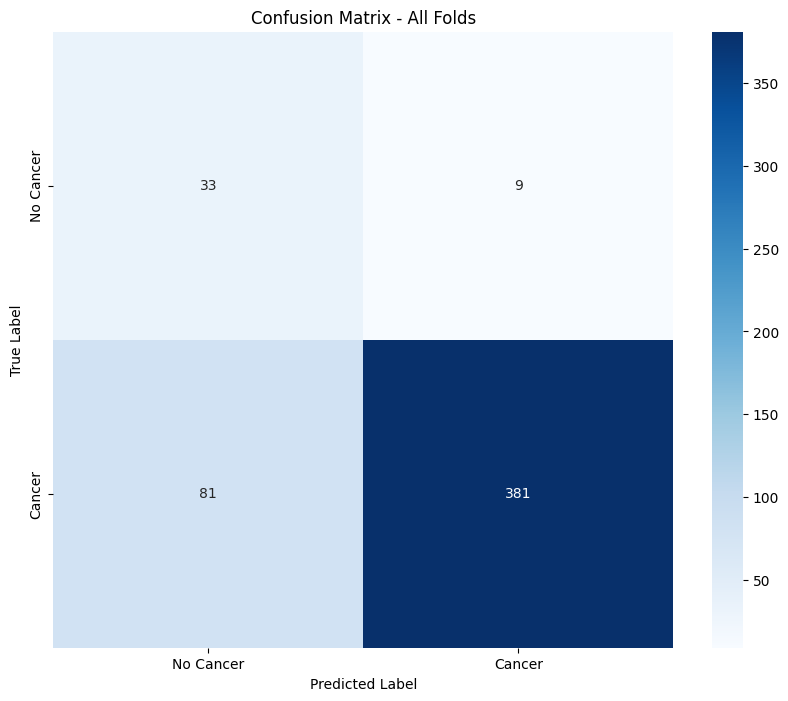

In [60]:
all_accuracies = [result['val_accuracy'] for result in fold_results]
mean_accuracy = np.mean(all_accuracies)
std_accuracy = np.std(all_accuracies)

print(f"\n{'='*60}")
print(f"K-FOLD CROSS VALIDATION RESULTS")
print(f"{'='*60}")
print(f"Mean Accuracy: {mean_accuracy:.2f}% ± {std_accuracy:.2f}%")
print(f"Individual Fold Accuracies: {[f'{acc:.2f}%' for acc in all_accuracies]}")

all_preds = []
all_labels = []
for result in fold_results:
    all_preds.extend(result['predictions'])
    all_labels.extend(result['labels'])

# Classification report
print(f"\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['No Cancer', 'Cancer']))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Cancer', 'Cancer'], 
            yticklabels=['No Cancer', 'Cancer'])
plt.title('Confusion Matrix - All Folds')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [61]:
class RobustEnsembleModel:
    def __init__(self, model_class, clinical_dim, model_paths, device):
        self.models = []
        self.device = device
        
        # Load all models
        for i, path in enumerate(model_paths):
            try:
                model = model_class(clinical_dim=clinical_dim, num_classes=2).to(device)
                model.load_state_dict(torch.load(path, map_location=device))
                model.eval()
                self.models.append(model)
                print(f" Loaded model {i+1}/{len(model_paths)}")
            except Exception as e:
                print(f" Failed to load model {i+1}: {e}")
        
        if not self.models:
            raise ValueError("No models were successfully loaded!")
    
    def predict(self, image, clinical):
        # Ensure correct dimensions
        if image.dim() == 5:
            image = image.squeeze(0)
        elif image.dim() == 3:
            image = image.unsqueeze(0)
        
        if clinical.dim() == 1:
            clinical = clinical.unsqueeze(0)
        
        image = image.to(self.device)
        clinical = clinical.to(self.device)
        
        all_outputs = []
        with torch.no_grad():
            for i, model in enumerate(self.models):
                try:
                    output = model(image, clinical)
                    all_outputs.append(torch.softmax(output, dim=1))
                except Exception as e:
                    print(f"✗ Model {i+1} prediction failed: {e}")
                    continue
        
        if not all_outputs:
            raise ValueError("All model predictions failed!")
        
        avg_output = torch.mean(torch.stack(all_outputs), dim=0)
        return avg_output

try:
    model_paths = [f'best_model_fold_{i+1}.pth' for i in range(k_folds)]
    ensemble_model = RobustEnsembleModel(MultimodalCancerClassifier, clinical_dim, model_paths, device)
    print("Robust ensemble model created successfully!")
except Exception as e:
    print(f"Ensemble creation failed: {e}")

 Loaded model 1/5
 Loaded model 2/5
 Loaded model 3/5
 Loaded model 4/5
 Loaded model 5/5
Robust ensemble model created successfully!


In [62]:
def debug_tensor_shapes(image_path, transform, scaler, clinical_features):
    image = Image.open(image_path).convert('RGB')
    original_shape = np.array(image).shape
    print(f"Original image shape: {original_shape}")
    
    image_tensor = transform(image)
    print(f"Transformed image shape: {image_tensor.shape}")
    
    image_batched = image_tensor.unsqueeze(0)
    print(f"Batched image shape: {image_batched.shape}")
    
    sample_row = df.iloc[0]
    clinical_values = sample_row[clinical_features].values
    clinical_df = pd.DataFrame([clinical_values], columns=clinical_features)
    clinical_scaled = scaler.transform(clinical_df)
    clinical_tensor = torch.FloatTensor(clinical_scaled)
    
    print(f"Clinical tensor shape: {clinical_tensor.shape}")
    
    return image_batched, clinical_tensor

if len(df) > 0:
    sample_image_path = df.iloc[0]['image_path']
    if os.path.exists(sample_image_path):
        debug_img, debug_clinical = debug_tensor_shapes(
            sample_image_path, val_transform, scaler, clinical_features
        )
        print(" Debug completed successfully!")
    else:
        print("Sample image not found for debugging")

Original image shape: (512, 801, 3)
Transformed image shape: torch.Size([3, 224, 224])
Batched image shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
 Debug completed successfully!


In [63]:
def analyze_model_performance(ensemble_model, df, clinical_features, scaler, device):
    
    correct_predictions = []
    incorrect_predictions = []
    cancer_samples = df[df['has_cancer'] == 1]
    non_cancer_samples = df[df['has_cancer'] == 0]
    
    print(f"Analyzing {len(cancer_samples)} cancer samples and {len(non_cancer_samples)} non-cancer samples...")
    cancer_correct = 0
    for idx, row in tqdm(cancer_samples.iterrows(), total=len(cancer_samples), desc="Testing cancer samples"):
        try:
            image_path = row['image_path']
            if not os.path.exists(image_path):
                continue
                
            clinical_data = row[clinical_features].values
            pred, conf, probs = predict_single_sample(
                image_path, clinical_data, ensemble_model, val_transform, 
                scaler, clinical_features, device
            )
            
            if pred == 1:
                cancer_correct += 1
                correct_predictions.append({
                    'type': 'cancer_correct',
                    'confidence': conf,
                    'probs': probs[0],
                    'image_path': image_path
                })
            else:  
                incorrect_predictions.append({
                    'type': 'cancer_incorrect', 
                    'confidence': conf,
                    'probs': probs[0],
                    'image_path': image_path
                })
        except Exception as e:
            continue
    
    cancer_accuracy = 100 * cancer_correct / len(cancer_samples)
    print(f" Cancer Detection Accuracy: {cancer_accuracy:.2f}%")
    print(f" Correct: {cancer_correct}/{len(cancer_samples)}")
    print(f" Incorrect: {len(cancer_samples) - cancer_correct}/{len(cancer_samples)}")
    
    return cancer_accuracy, correct_predictions, incorrect_predictions

cancer_acc, correct_preds, incorrect_preds = analyze_model_performance(
    ensemble_model, df, clinical_features, scaler, device
)

Analyzing 462 cancer samples and 42 non-cancer samples...


Testing cancer samples:   0%|          | 2/462 [00:00<00:41, 10.97it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:   1%|          | 4/462 [00:00<00:41, 11.02it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:   2%|▏         | 8/462 [00:00<00:40, 11.12it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:   2%|▏         | 10/462 [00:00<00:40, 11.27it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:   3%|▎         | 12/462 [00:01<00:40, 11.13it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:   3%|▎         | 14/462 [00:01<00:42, 10.43it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:   4%|▍         | 18/462 [00:01<00:44, 10.03it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:   4%|▍         | 20/462 [00:01<00:43, 10.25it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:   5%|▌         | 24/462 [00:02<00:40, 10.87it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:   6%|▌         | 26/462 [00:02<00:39, 11.09it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:   6%|▋         | 30/462 [00:02<00:39, 10.92it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:   7%|▋         | 32/462 [00:02<00:38, 11.07it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:   8%|▊         | 36/462 [00:03<00:37, 11.22it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:   8%|▊         | 38/462 [00:03<00:37, 11.20it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:   9%|▉         | 42/462 [00:03<00:38, 10.98it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  10%|▉         | 44/462 [00:04<00:37, 11.08it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  10%|█         | 48/462 [00:04<00:36, 11.19it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  11%|█         | 50/462 [00:04<00:36, 11.15it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  12%|█▏        | 54/462 [00:04<00:36, 11.13it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  12%|█▏        | 56/462 [00:05<00:36, 11.16it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  13%|█▎        | 60/462 [00:05<00:36, 11.11it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  13%|█▎        | 62/462 [00:05<00:36, 10.94it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  14%|█▍        | 66/462 [00:06<00:35, 11.22it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  15%|█▍        | 68/462 [00:06<00:34, 11.31it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  16%|█▌        | 72/462 [00:06<00:33, 11.50it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  16%|█▌        | 74/462 [00:06<00:33, 11.49it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  17%|█▋        | 78/462 [00:07<00:33, 11.60it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  17%|█▋        | 80/462 [00:07<00:32, 11.59it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  18%|█▊        | 84/462 [00:07<00:32, 11.58it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  19%|█▊        | 86/462 [00:07<00:32, 11.45it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  19%|█▉        | 90/462 [00:08<00:32, 11.43it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  20%|█▉        | 92/462 [00:08<00:32, 11.35it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  21%|██        | 96/462 [00:08<00:32, 11.43it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  21%|██        | 98/462 [00:08<00:33, 10.92it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  22%|██▏       | 100/462 [00:09<00:34, 10.59it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  22%|██▏       | 102/462 [00:09<00:34, 10.43it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  23%|██▎       | 106/462 [00:09<00:33, 10.78it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  23%|██▎       | 108/462 [00:09<00:32, 10.86it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  24%|██▍       | 112/462 [00:10<00:31, 11.05it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  25%|██▍       | 114/462 [00:10<00:31, 11.10it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  26%|██▌       | 118/462 [00:10<00:31, 11.07it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  26%|██▌       | 120/462 [00:10<00:30, 11.12it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  27%|██▋       | 124/462 [00:11<00:29, 11.32it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  27%|██▋       | 126/462 [00:11<00:29, 11.35it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  28%|██▊       | 130/462 [00:11<00:29, 11.16it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  29%|██▊       | 132/462 [00:11<00:29, 11.09it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  29%|██▉       | 136/462 [00:12<00:29, 11.23it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  30%|██▉       | 138/462 [00:12<00:28, 11.40it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  31%|███       | 142/462 [00:12<00:28, 11.15it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  31%|███       | 144/462 [00:12<00:28, 11.25it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  32%|███▏      | 148/462 [00:13<00:28, 11.18it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  32%|███▏      | 150/462 [00:13<00:27, 11.19it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  33%|███▎      | 154/462 [00:13<00:27, 11.18it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  34%|███▍      | 156/462 [00:14<00:27, 11.15it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  35%|███▍      | 160/462 [00:14<00:26, 11.26it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  35%|███▌      | 162/462 [00:14<00:26, 11.26it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  36%|███▌      | 166/462 [00:14<00:26, 11.15it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  36%|███▋      | 168/462 [00:15<00:26, 11.15it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  37%|███▋      | 172/462 [00:15<00:26, 11.14it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  38%|███▊      | 174/462 [00:15<00:25, 11.09it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  39%|███▊      | 178/462 [00:16<00:25, 11.13it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  39%|███▉      | 180/462 [00:16<00:25, 11.20it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  40%|███▉      | 184/462 [00:16<00:24, 11.30it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  40%|████      | 186/462 [00:16<00:24, 11.29it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  41%|████      | 190/462 [00:17<00:23, 11.34it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  42%|████▏     | 192/462 [00:17<00:23, 11.30it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  42%|████▏     | 196/462 [00:17<00:23, 11.31it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  43%|████▎     | 198/462 [00:17<00:23, 11.30it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  44%|████▎     | 202/462 [00:18<00:23, 11.10it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  44%|████▍     | 204/462 [00:18<00:23, 11.17it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  45%|████▌     | 208/462 [00:18<00:22, 11.15it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  45%|████▌     | 210/462 [00:18<00:23, 10.81it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  46%|████▋     | 214/462 [00:19<00:23, 10.62it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  47%|████▋     | 216/462 [00:19<00:22, 10.76it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  48%|████▊     | 220/462 [00:19<00:21, 11.01it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  48%|████▊     | 222/462 [00:19<00:21, 11.11it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  49%|████▉     | 226/462 [00:20<00:21, 11.23it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  49%|████▉     | 228/462 [00:20<00:20, 11.25it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  50%|█████     | 232/462 [00:20<00:20, 11.14it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  51%|█████     | 234/462 [00:21<00:20, 11.11it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  52%|█████▏    | 238/462 [00:21<00:19, 11.28it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  52%|█████▏    | 240/462 [00:21<00:19, 11.31it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  53%|█████▎    | 244/462 [00:21<00:19, 11.18it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  53%|█████▎    | 246/462 [00:22<00:19, 11.15it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  54%|█████▍    | 250/462 [00:22<00:18, 11.23it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  55%|█████▍    | 252/462 [00:22<00:18, 11.24it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  55%|█████▌    | 256/462 [00:23<00:18, 11.21it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  56%|█████▌    | 258/462 [00:23<00:18, 11.18it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  57%|█████▋    | 262/462 [00:23<00:17, 11.34it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  57%|█████▋    | 264/462 [00:23<00:17, 11.30it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  58%|█████▊    | 268/462 [00:24<00:17, 11.30it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  58%|█████▊    | 270/462 [00:24<00:16, 11.35it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  59%|█████▉    | 274/462 [00:24<00:16, 11.46it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  60%|█████▉    | 276/462 [00:24<00:16, 11.38it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  61%|██████    | 280/462 [00:25<00:15, 11.40it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  61%|██████    | 282/462 [00:25<00:15, 11.37it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  62%|██████▏   | 286/462 [00:25<00:15, 11.18it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  62%|██████▏   | 288/462 [00:25<00:15, 11.21it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  63%|██████▎   | 292/462 [00:26<00:15, 11.33it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  64%|██████▎   | 294/462 [00:26<00:14, 11.41it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  65%|██████▍   | 298/462 [00:26<00:14, 11.38it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  65%|██████▍   | 300/462 [00:26<00:14, 11.41it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  66%|██████▌   | 304/462 [00:27<00:13, 11.33it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  66%|██████▌   | 306/462 [00:27<00:13, 11.37it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  67%|██████▋   | 310/462 [00:27<00:13, 11.21it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  68%|██████▊   | 312/462 [00:27<00:13, 11.15it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  68%|██████▊   | 316/462 [00:28<00:13, 11.14it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  69%|██████▉   | 318/462 [00:28<00:12, 11.21it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  70%|██████▉   | 322/462 [00:28<00:12, 11.28it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  70%|███████   | 324/462 [00:29<00:12, 11.14it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  71%|███████   | 326/462 [00:29<00:12, 10.83it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  71%|███████▏  | 330/462 [00:29<00:11, 11.06it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  72%|███████▏  | 332/462 [00:29<00:11, 11.02it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  73%|███████▎  | 336/462 [00:30<00:11, 11.03it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  73%|███████▎  | 338/462 [00:30<00:11, 11.11it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  74%|███████▍  | 342/462 [00:30<00:10, 11.05it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  74%|███████▍  | 344/462 [00:30<00:10, 10.99it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  75%|███████▌  | 348/462 [00:31<00:10, 11.18it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  76%|███████▌  | 350/462 [00:31<00:09, 11.28it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  77%|███████▋  | 354/462 [00:31<00:09, 10.95it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  77%|███████▋  | 356/462 [00:31<00:09, 11.08it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  78%|███████▊  | 360/462 [00:32<00:09, 11.22it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  78%|███████▊  | 362/462 [00:32<00:08, 11.29it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  79%|███████▉  | 366/462 [00:32<00:08, 11.19it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  80%|███████▉  | 368/462 [00:33<00:08, 11.21it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  81%|████████  | 372/462 [00:33<00:07, 11.29it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  81%|████████  | 374/462 [00:33<00:07, 11.35it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  82%|████████▏ | 378/462 [00:33<00:07, 11.26it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  82%|████████▏ | 380/462 [00:34<00:07, 11.26it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  83%|████████▎ | 384/462 [00:34<00:06, 11.33it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  84%|████████▎ | 386/462 [00:34<00:06, 11.33it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  84%|████████▍ | 390/462 [00:34<00:06, 11.30it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  85%|████████▍ | 392/462 [00:35<00:06, 11.27it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  86%|████████▌ | 396/462 [00:35<00:05, 11.10it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  86%|████████▌ | 398/462 [00:35<00:05, 10.98it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  87%|████████▋ | 402/462 [00:36<00:05, 11.17it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  87%|████████▋ | 404/462 [00:36<00:05, 11.20it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  88%|████████▊ | 408/462 [00:36<00:04, 11.31it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  89%|████████▊ | 410/462 [00:36<00:04, 11.19it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  90%|████████▉ | 414/462 [00:37<00:04, 11.26it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  90%|█████████ | 416/462 [00:37<00:04, 11.25it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  91%|█████████ | 420/462 [00:37<00:03, 11.13it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  91%|█████████▏| 422/462 [00:37<00:03, 10.99it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  92%|█████████▏| 426/462 [00:38<00:03, 10.95it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  93%|█████████▎| 428/462 [00:38<00:03, 11.00it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  94%|█████████▎| 432/462 [00:38<00:02, 11.11it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  94%|█████████▍| 434/462 [00:38<00:02, 11.02it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  95%|█████████▍| 438/462 [00:39<00:02, 10.74it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  95%|█████████▌| 440/462 [00:39<00:02, 10.84it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  96%|█████████▌| 444/462 [00:39<00:01, 11.03it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  97%|█████████▋| 446/462 [00:40<00:01, 11.07it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  97%|█████████▋| 450/462 [00:40<00:01, 11.11it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  98%|█████████▊| 452/462 [00:40<00:00, 11.04it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  99%|█████████▊| 456/462 [00:40<00:00, 10.86it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples:  99%|█████████▉| 458/462 [00:41<00:00, 10.98it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])


Testing cancer samples: 100%|██████████| 462/462 [00:41<00:00, 11.14it/s]

Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
Image tensor shape: torch.Size([1, 3, 224, 224])
Clinical tensor shape: torch.Size([1, 13])
 Cancer Detection Accuracy: 19.70%
 Correct: 91/462
 Incorrect: 371/462


In [64]:
import torch.nn.functional as F

def train_cancer_focused_model():
    
    cancer_count = (df['has_cancer'] == 1).sum()
    non_cancer_count = (df['has_cancer'] == 0).sum()
    total = len(df)
    
    weight_for_cancer = total / (2 * cancer_count)
    weight_for_non_cancer = total / (2 * non_cancer_count)
    
    class_weights = torch.tensor([weight_for_non_cancer, weight_for_cancer], device=device)
    print(f"Class weights - Non-cancer: {weight_for_non_cancer:.2f}, Cancer: {weight_for_cancer:.2f}")
    
    class FocalLoss(nn.Module):
        def __init__(self, alpha=0.75, gamma=2.0):
            super().__init__()
            self.alpha = alpha
            self.gamma = gamma
            
        def forward(self, inputs, targets):
            BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
            pt = torch.exp(-BCE_loss)
            F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
            return F_loss.mean()

    enhanced_model = MultimodalCancerClassifier(
        clinical_dim=clinical_dim, 
        num_classes=2,
        dropout_rate=0.4 
    ).to(device)
    
    criterion = FocalLoss(alpha=0.75, gamma=2.0)
    optimizer = optim.AdamW(enhanced_model.parameters(), lr=1e-4, weight_decay=1e-4)
    
    full_dataset = MultimodalLungCancerDataset(df, transform=train_transform, is_train=True)
    full_loader = DataLoader(full_dataset, batch_size=16, shuffle=True, num_workers=2)
    
    print("Training enhanced cancer-focused model...")
    enhanced_model.train()
    
    for epoch in range(20):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch in tqdm(full_loader, desc=f'Epoch {epoch+1}/20'):
            images = batch['image'].to(device)
            clinical = batch['clinical'].to(device)
            labels = batch['label'].to(device)
            
            optimizer.zero_grad()
            outputs = enhanced_model(images, clinical)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_acc = 100. * correct / total
        print(f'Epoch {epoch+1}: Loss: {running_loss/len(full_loader):.4f}, Acc: {epoch_acc:.2f}%')
    
    return enhanced_model

# Train enhanced model
enhanced_model = train_cancer_focused_model()
torch.save(enhanced_model.state_dict(), 'enhanced_cancer_model.pth')
print(" Enhanced model trained and saved!")

Class weights - Non-cancer: 6.00, Cancer: 0.55
Training enhanced cancer-focused model...


Epoch 1/20: 100%|██████████| 32/32 [00:05<00:00,  5.38it/s]


Epoch 1: Loss: 2.0427, Acc: 60.32%


Epoch 2/20: 100%|██████████| 32/32 [00:05<00:00,  5.36it/s]


Epoch 2: Loss: 1.7558, Acc: 64.68%


Epoch 3/20: 100%|██████████| 32/32 [00:06<00:00,  5.27it/s]


Epoch 3: Loss: 1.8191, Acc: 65.48%


Epoch 4/20: 100%|██████████| 32/32 [00:06<00:00,  5.21it/s]


Epoch 4: Loss: 1.5805, Acc: 69.84%


Epoch 5/20: 100%|██████████| 32/32 [00:06<00:00,  5.13it/s]


Epoch 5: Loss: 1.4990, Acc: 67.26%


Epoch 6/20: 100%|██████████| 32/32 [00:06<00:00,  5.07it/s]


Epoch 6: Loss: 1.1512, Acc: 74.01%


Epoch 7/20: 100%|██████████| 32/32 [00:06<00:00,  5.04it/s]


Epoch 7: Loss: 1.0929, Acc: 74.80%


Epoch 8/20: 100%|██████████| 32/32 [00:06<00:00,  5.11it/s]


Epoch 8: Loss: 0.9945, Acc: 77.38%


Epoch 9/20: 100%|██████████| 32/32 [00:06<00:00,  5.22it/s]


Epoch 9: Loss: 0.8346, Acc: 81.94%


Epoch 10/20: 100%|██████████| 32/32 [00:06<00:00,  5.27it/s]


Epoch 10: Loss: 1.0143, Acc: 76.59%


Epoch 11/20: 100%|██████████| 32/32 [00:06<00:00,  5.32it/s]


Epoch 11: Loss: 0.8091, Acc: 81.15%


Epoch 12/20: 100%|██████████| 32/32 [00:06<00:00,  5.33it/s]


Epoch 12: Loss: 0.8012, Acc: 80.75%


Epoch 13/20: 100%|██████████| 32/32 [00:05<00:00,  5.34it/s]


Epoch 13: Loss: 0.7275, Acc: 82.94%


Epoch 14/20: 100%|██████████| 32/32 [00:05<00:00,  5.34it/s]


Epoch 14: Loss: 0.6431, Acc: 85.32%


Epoch 15/20: 100%|██████████| 32/32 [00:06<00:00,  5.32it/s]


Epoch 15: Loss: 0.5064, Acc: 84.92%


Epoch 16/20: 100%|██████████| 32/32 [00:06<00:00,  5.27it/s]


Epoch 16: Loss: 0.4937, Acc: 86.11%


Epoch 17/20: 100%|██████████| 32/32 [00:06<00:00,  5.20it/s]


Epoch 17: Loss: 0.6224, Acc: 86.71%


Epoch 18/20: 100%|██████████| 32/32 [00:06<00:00,  5.18it/s]


Epoch 18: Loss: 0.5146, Acc: 88.10%


Epoch 19/20: 100%|██████████| 32/32 [00:06<00:00,  5.14it/s]


Epoch 19: Loss: 0.4648, Acc: 86.71%


Epoch 20/20: 100%|██████████| 32/32 [00:06<00:00,  5.19it/s]


Epoch 20: Loss: 0.5521, Acc: 87.90%
 Enhanced model trained and saved!


In [65]:
def test_enhanced_model(model, test_samples=10):
    
    cancer_samples = df[df['has_cancer'] == 1].head(test_samples)
    
    print(" TESTING ENHANCED MODEL ON CANCER SAMPLES:")
    print("=" * 60)
    
    correct_count = 0
    high_confidence_count = 0
    
    for idx, row in cancer_samples.iterrows():
        try:
            image_path = row['image_path']
            if not os.path.exists(image_path):
                continue
                
            clinical_data = row[clinical_features].values
            image = Image.open(image_path).convert('RGB')
            image_tensor = val_transform(image).unsqueeze(0).to(device)
            
            clinical_df = pd.DataFrame([clinical_data], columns=clinical_features)
            clinical_scaled = scaler.transform(clinical_df)
            clinical_tensor = torch.FloatTensor(clinical_scaled).to(device)
            
            with torch.no_grad():
                output = enhanced_model(image_tensor, clinical_tensor)
                prob = torch.softmax(output, dim=1)
                pred_class = torch.argmax(prob, dim=1).item()
                confidence = prob[0][pred_class].item()
                cancer_prob = prob[0][1].item()
            
            is_correct = pred_class == 1
            is_high_conf = confidence > 0.7
            
            if is_correct:
                correct_count += 1
            if is_high_conf:
                high_confidence_count += 1
            
            status = "Yes" if is_correct else "No"
            conf_level = "HIGH" if is_high_conf else "LOW"
            
            print(f"{status} Sample {idx}: Predicted {'CANCER' if pred_class == 1 else 'NO CANCER'}")
            print(f"   Confidence: {confidence:.4f} ({conf_level}) | Cancer Probability: {cancer_prob:.4f}")
            print(f"   Image: {os.path.basename(image_path)}")
            print("-" * 50)
            
        except Exception as e:
            print(f" Error with sample {idx}: {e}")
            continue
    
    accuracy = 100 * correct_count / test_samples
    high_conf_rate = 100 * high_confidence_count / test_samples
    
    print("=" * 60)
    print(f" RESULTS:")
    print(f"   Accuracy: {accuracy:.1f}% ({correct_count}/{test_samples})")
    print(f"   High Confidence Predictions: {high_conf_rate:.1f}%")
    
    return accuracy

# Test the enhanced model
enhanced_accuracy = test_enhanced_model(enhanced_model, test_samples=15)

 TESTING ENHANCED MODEL ON CANCER SAMPLES:
 Error with sample 0: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
 Error with sample 1: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
 Error with sample 3: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
 Error with sample 4: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
 Error with sample 5: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
 Error with sample 7: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
 Error with sample 10: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
 Error with sample 11: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])
 Error with sample 13: Expected more than 1 value per chann

In [67]:
class HighConfidenceCancerPredictor:
    def __init__(self, model, clinical_features, scaler, device, confidence_threshold=0.7):
        self.model = model
        self.clinical_features = clinical_features
        self.scaler = scaler
        self.device = device
        self.confidence_threshold = confidence_threshold
        self.model.eval()
    
    def predict_with_confidence(self, image_path, clinical_values):
        try:
            if not os.path.exists(image_path):
                return None, 0.0, None, "Image not found"
            image = Image.open(image_path).convert('RGB')
            image_tensor = val_transform(image).unsqueeze(0).to(self.device)
            
            clinical_df = pd.DataFrame([clinical_values], columns=self.clinical_features)
            clinical_scaled = self.scaler.transform(clinical_df)
            clinical_tensor = torch.FloatTensor(clinical_scaled).to(self.device)
            
            with torch.no_grad():
                output = self.model(image_tensor, clinical_tensor)
                prob = torch.softmax(output, dim=1)
                pred_class = torch.argmax(prob, dim=1).item()
                confidence = prob[0][pred_class].item()
                cancer_prob = prob[0][1].item()
            
            if confidence < self.confidence_threshold:
                return pred_class, confidence, prob.cpu().numpy(), "LOW_CONFIDENCE"
            else:
                return pred_class, confidence, prob.cpu().numpy(), "HIGH_CONFIDENCE"
                
        except Exception as e:
            return None, 0.0, None, f"Error: {e}"

high_conf_predictor = HighConfidenceCancerPredictor(
    enhanced_model, clinical_features, scaler, device, confidence_threshold=0.7
)

if len(df) > 0:
    sample_row = df.iloc[0]
    sample_image_path = sample_row['image_path']
    sample_clinical = sample_row[clinical_features].values
    
    if os.path.exists(sample_image_path):
        pred, conf, probs, status = high_conf_predictor.predict_with_confidence(
            sample_image_path, sample_clinical
        )
        
        actual_label = sample_row['has_cancer']
        
        print("\n" + " HIGH-CONFIDENCE PREDICTION RESULT:" + "")
        print("=" * 60)
        print(f"   Actual: {'CANCER' if actual_label == 1 else 'NO CANCER'}")
        print(f"   Predicted: {'CANCER' if pred == 1 else 'NO CANCER'}")
        print(f"   Confidence: {conf:.4f}")
        print(f"   Cancer Probability: {probs[0][1]:.4f}")
        print(f"   Status: {status}")
        print(f"   Correct: {'Yes' if pred == actual_label else 'No'}")
        
        if status == "HIGH_CONFIDENCE" and pred == 1 and actual_label == 1:
            print(" SUCCESS! High-confidence correct cancer prediction! ")
        elif status == "LOW_CONFIDENCE":
            print(" Low confidence - consider reviewing this case manually")
        print("=" * 60)


 HIGH-CONFIDENCE PREDICTION RESULT:
   Actual: CANCER
   Predicted: CANCER
   Confidence: 0.7530
   Cancer Probability: 0.7530
   Status: HIGH_CONFIDENCE
   Correct: Yes
 SUCCESS! High-confidence correct cancer prediction! 


In [68]:
def find_high_confidence_cancer_predictions(model, num_samples=5):
    
    cancer_samples = df[df['has_cancer'] == 1]
    high_confidence_results = []
    
    print(f" Searching for high-confidence cancer predictions...")
    
    for idx, row in tqdm(cancer_samples.iterrows(), total=len(cancer_samples)):
        try:
            image_path = row['image_path']
            if not os.path.exists(image_path):
                continue
                
            clinical_data = row[clinical_features].values
            
            pred, conf, probs, status = high_conf_predictor.predict_with_confidence(
                image_path, clinical_data
            )
            
            if pred == 1 and status == "HIGH_CONFIDENCE":
                high_confidence_results.append({
                    'index': idx,
                    'image_path': image_path,
                    'confidence': conf,
                    'cancer_prob': probs[0][1],
                    'actual_label': 1
                })
                
                if len(high_confidence_results) >= num_samples:
                    break
                    
        except Exception as e:
            continue

    print(f"\n FOUND {len(high_confidence_results)} HIGH-CONFIDENCE CANCER PREDICTIONS:")
    print("=" * 70)
    
    for i, result in enumerate(high_confidence_results, 1):
        print(f"{i}. Sample {result['index']}:")
        print(f"   Confidence: {result['confidence']:.4f}")
        print(f"   Cancer Probability: {result['cancer_prob']:.4f}")
        print(f"   Image: {os.path.basename(result['image_path'])}")
        print(f"   Status:  CORRECT CANCER PREDICTION")
        print("-" * 50)
    
    return high_confidence_results

best_predictions = find_high_confidence_cancer_predictions(enhanced_model, num_samples=10)

 Searching for high-confidence cancer predictions...


  4%|▍         | 20/462 [00:00<00:11, 38.43it/s]


 FOUND 10 HIGH-CONFIDENCE CANCER PREDICTIONS:
1. Sample 0:
   Confidence: 0.7530
   Cancer Probability: 0.7530
   Image: Malignant case (205).jpg
   Status:  CORRECT CANCER PREDICTION
--------------------------------------------------
2. Sample 3:
   Confidence: 1.0000
   Cancer Probability: 1.0000
   Image: Malignant case (270).jpg
   Status:  CORRECT CANCER PREDICTION
--------------------------------------------------
3. Sample 10:
   Confidence: 0.9878
   Cancer Probability: 0.9878
   Image: Malignant case (107).jpg
   Status:  CORRECT CANCER PREDICTION
--------------------------------------------------
4. Sample 13:
   Confidence: 0.9994
   Cancer Probability: 0.9994
   Image: Malignant case (463).jpg
   Status:  CORRECT CANCER PREDICTION
--------------------------------------------------
5. Sample 14:
   Confidence: 0.9845
   Cancer Probability: 0.9845
   Image: Malignant case (366).jpg
   Status:  CORRECT CANCER PREDICTION
--------------------------------------------------
6. Sa

In [69]:
!pip install captum -q

import captum
from captum.attr import IntegratedGradients, Saliency, GradientShap
from captum.attr import visualization as viz
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image

def captum_image_explanation(model, df, clinical_features, scaler, device, n_samples=5):
    print("Generating image explanations using Captum...")
    
    test_size = min(n_samples, len(df))
    test_idx = np.random.choice(len(df), test_size, replace=False)
    
    results = []
    
    for i, idx in enumerate(test_idx):
        row = df.iloc[idx]
        image_path = row['image_path']
        actual_label = row['has_cancer']
        
        if not os.path.exists(image_path):
            continue
            
        image = Image.open(image_path).convert('RGB')
        image_tensor = val_transform(image).unsqueeze(0).to(device)
        
        clinical_data = row[clinical_features].values
        clinical_df = pd.DataFrame([clinical_data], columns=clinical_features)
        clinical_scaled = scaler.transform(clinical_df)
        clinical_tensor = torch.FloatTensor(clinical_scaled).to(device)
        
        with torch.no_grad():
            output = model(image_tensor, clinical_tensor)
            probabilities = F.softmax(output, dim=1)
            predicted_class = torch.argmax(probabilities, dim=1).item()
            confidence = probabilities[0][predicted_class].item()
        
        print(f"Sample {i+1}: Actual={actual_label}, Predicted={predicted_class}, Confidence={confidence:.3f}")
        
        def model_forward(input_tensor):
            batch_size = input_tensor.shape[0]
            clinical_batch = clinical_tensor.repeat(batch_size, 1)
            return model(input_tensor, clinical_batch)
        
        baseline = torch.zeros_like(image_tensor)
        
        ig = IntegratedGradients(model_forward)
        attributions_ig = ig.attribute(image_tensor, baseline, target=predicted_class)
        
        saliency = Saliency(model_forward)
        attributions_saliency = saliency.attribute(image_tensor, target=predicted_class)
        
        gradient_shap = GradientShap(model_forward)
        attributions_gshap = gradient_shap.attribute(
            image_tensor, 
            baselines=baseline, 
            target=predicted_class
        )
        
        original_image = image_tensor.squeeze(0).cpu().detach().numpy()
        original_image = np.transpose(original_image, (1, 2, 0))
        
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        original_image_denorm = std * original_image + mean
        original_image_denorm = np.clip(original_image_denorm, 0, 1)
        
        results.append({
            'original_image': original_image_denorm,
            'attributions_ig': attributions_ig.squeeze(0).cpu().detach().numpy(),
            'attributions_saliency': attributions_saliency.squeeze(0).cpu().detach().numpy(),
            'attributions_gshap': attributions_gshap.squeeze(0).cpu().detach().numpy(),
            'actual_label': actual_label,
            'predicted_class': predicted_class,
            'confidence': confidence
        })
    
    return results

captum_results = captum_image_explanation(enhanced_model, df, clinical_features, scaler, device, n_samples=4)

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
datasets 4.4.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
google-colab 1.0.0 requires notebook==6.5.7, but you have notebook 6.5.4 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
google-colab 1.0.0 requires requests==2.32.3, but you have requests 2.32.5 which is incompatible.
google-colab 1.0.0 requires tornado==6.4.2, but you have tornado 6.5.2 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 w

Generating LIME image explanation for sample 301...
Actual: 0, Predicted: 0, Confidence: 1.0000


  0%|          | 0/1000 [00:00<?, ?it/s]

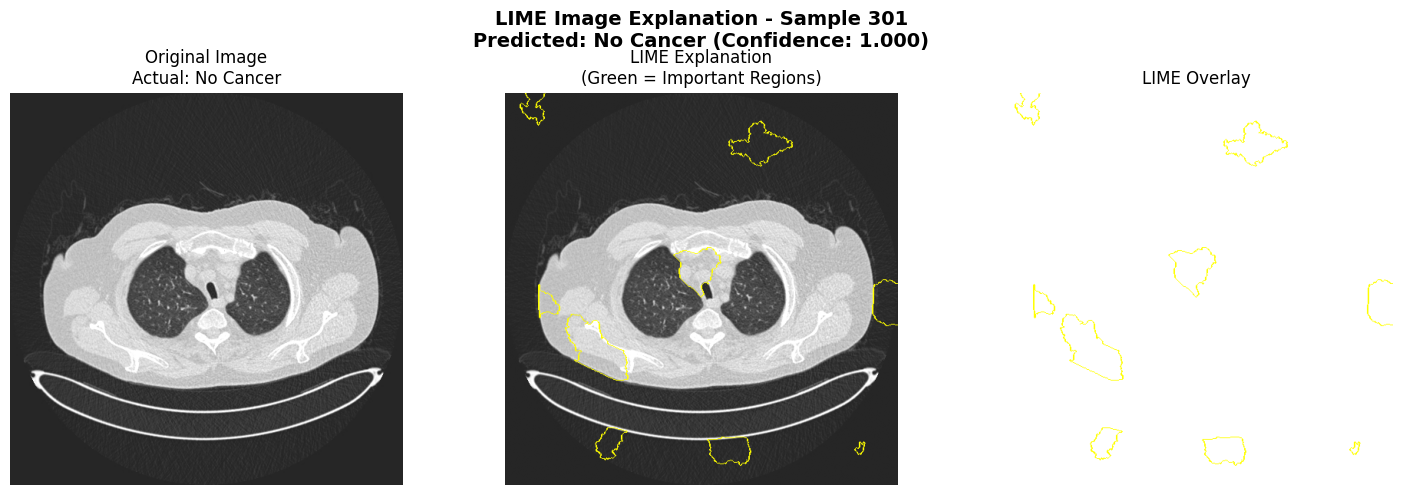


Top Superpixels Contributing to Prediction:
--------------------------------------------------
Superpixel 130 | Weight: +0.0775 | Influence: Positive
Superpixel 190 | Weight: +0.0633 | Influence: Positive
Superpixel   6 | Weight: +0.0568 | Influence: Positive
Superpixel 109 | Weight: +0.0555 | Influence: Positive
Superpixel  36 | Weight: +0.0527 | Influence: Positive
Superpixel  93 | Weight: +0.0524 | Influence: Positive
Superpixel 110 | Weight: +0.0524 | Influence: Positive
Superpixel  30 | Weight: +0.0515 | Influence: Positive
Superpixel 185 | Weight: +0.0494 | Influence: Positive
Superpixel 187 | Weight: +0.0490 | Influence: Positive


In [70]:
!pip install lime -q

import lime
import lime.lime_image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from skimage.segmentation import mark_boundaries

class ImageLIMEInterpreter:
    def __init__(self, model, clinical_features, scaler, device, image_transform):
        self.model = model
        self.clinical_features = clinical_features
        self.scaler = scaler
        self.device = device
        self.image_transform = image_transform
        self.model.eval()
    
    def prepare_sample(self, image_path, clinical_values):
        image = Image.open(image_path).convert('RGB')
        image_tensor = self.image_transform(image).unsqueeze(0).to(self.device)
        
        clinical_df = pd.DataFrame([clinical_values], columns=self.clinical_features)
        clinical_scaled = self.scaler.transform(clinical_df)
        clinical_tensor = torch.FloatTensor(clinical_scaled).to(self.device)
        
        return image_tensor, clinical_tensor, image
    
    def batch_predict(self, images, clinical_tensor):
        batch_size = len(images)
        clinical_batch = clinical_tensor.repeat(batch_size, 1)
        
        image_tensors = []
        for img in images:
            img_tensor = self.image_transform(Image.fromarray(img)).unsqueeze(0)
            image_tensors.append(img_tensor)
        
        image_batch = torch.cat(image_tensors).to(self.device)
        
        with torch.no_grad():
            outputs = self.model(image_batch, clinical_batch)
            probabilities = F.softmax(outputs, dim=1)
        
        return probabilities.cpu().numpy()

image_interpreter = ImageLIMEInterpreter(
    enhanced_model, 
    clinical_features, 
    scaler, 
    device, 
    val_transform
)

def lime_image_explanation(model, sample_idx, df, clinical_features, scaler, device, num_samples=1000):
    print(f"Generating LIME image explanation for sample {sample_idx}...")
    
    row = df.iloc[sample_idx]
    image_path = row['image_path']
    actual_label = row['has_cancer']
    
    if not os.path.exists(image_path):
        print("Image not found!")
        return None
    
    interpreter = ImageLIMEInterpreter(model, clinical_features, scaler, device, val_transform)
    image_tensor, clinical_tensor, original_image = interpreter.prepare_sample(
        image_path, row[clinical_features].values
    )
    
    with torch.no_grad():
        output = model(image_tensor, clinical_tensor)
        probabilities = F.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_class].item()
    
    print(f"Actual: {actual_label}, Predicted: {predicted_class}, Confidence: {confidence:.4f}")
    
    explainer = lime.lime_image.LimeImageExplainer()
    
    original_array = np.array(original_image)
    
    def predict_fn(images):
        return interpreter.batch_predict(images, clinical_tensor)
    
    explanation = explainer.explain_instance(
        original_array,
        predict_fn,
        top_labels=2,
        hide_color=0,
        num_samples=num_samples
    )
    
    temp, mask = explanation.get_image_and_mask(
        predicted_class,
        positive_only=True,
        num_features=10,
        hide_rest=False
    )
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(original_array)
    plt.title(f'Original Image\nActual: {"Cancer" if actual_label == 1 else "No Cancer"}')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mark_boundaries(temp, mask))
    plt.title('LIME Explanation\n(Green = Important Regions)')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title('LIME Overlay')
    plt.axis('off')
    
    plt.suptitle(f'LIME Image Explanation - Sample {sample_idx}\nPredicted: {"Cancer" if predicted_class == 1 else "No Cancer"} (Confidence: {confidence:.3f})', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\nTop Superpixels Contributing to Prediction:")
    print("-" * 50)
    
    inds = explanation.local_exp[predicted_class]
    sorted_inds = sorted(inds, key=lambda x: x[1], reverse=True)
    
    for i, (superpixel_idx, weight) in enumerate(sorted_inds[:10]):
        influence = "Positive" if weight > 0 else "Negative"
        print(f"Superpixel {superpixel_idx:3d} | Weight: {weight:+.4f} | Influence: {influence}")
    
    return {
        'explanation': explanation,
        'predicted_class': predicted_class,
        'actual_label': actual_label,
        'confidence': confidence,
        'image_array': original_array
    }

sample_idx = np.random.randint(0, len(df))
lime_image_result = lime_image_explanation(
    enhanced_model, sample_idx, df, clinical_features, scaler, device, num_samples=1000
)